In [ ]:
pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4465 sha256=96b4031570bbadd8f14953eaef17d55e9bf3d1a4f9115a010d3b66cb83b891f9
  Stored in directory: /root/.cache/pip/wheels/7d/2c/24/e130d6102c0df56631b9db7479d9a6a53c5d97fb06b5f61b98
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=46b7a1a0411ba8f45c966a5e240a64e402debf210262c8c01a0e82ff08a2c4e2
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built silence_tensorflow support_developer


In [ ]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/arsal_cv_proj/new'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [ ]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 40
number of classes in validation folder : 40
number of classes in test folder : 40


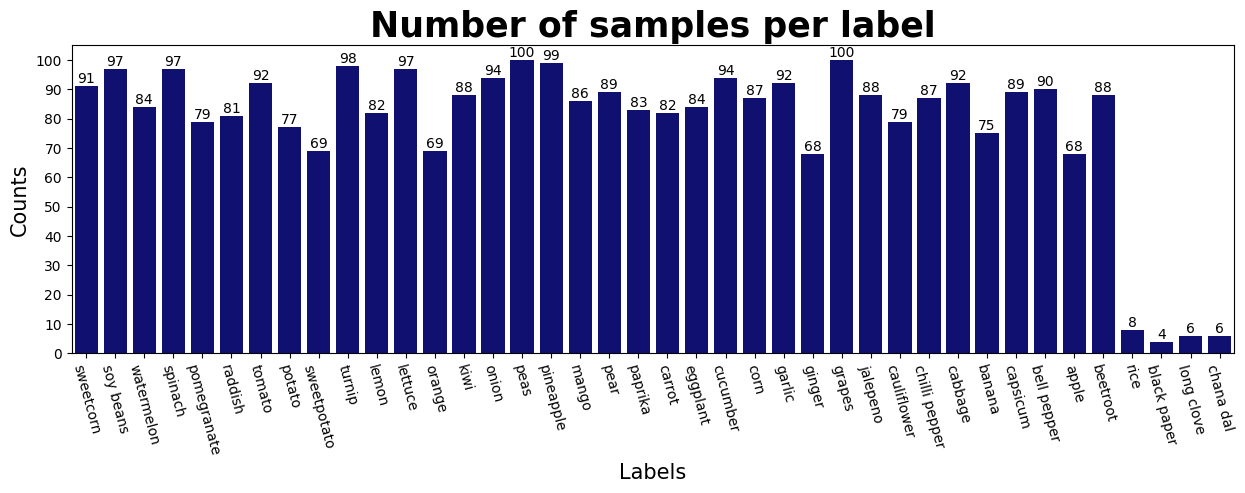

In [ ]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

In [ ]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [ ]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [ ]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 3139
Number of samples in validation : 360
Number of samples test : 370


In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:

# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

In [ ]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

In [ ]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=True
)

In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

In [ ]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    # print(layer.name)

In [ ]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [ ]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(40, activation='softmax'))

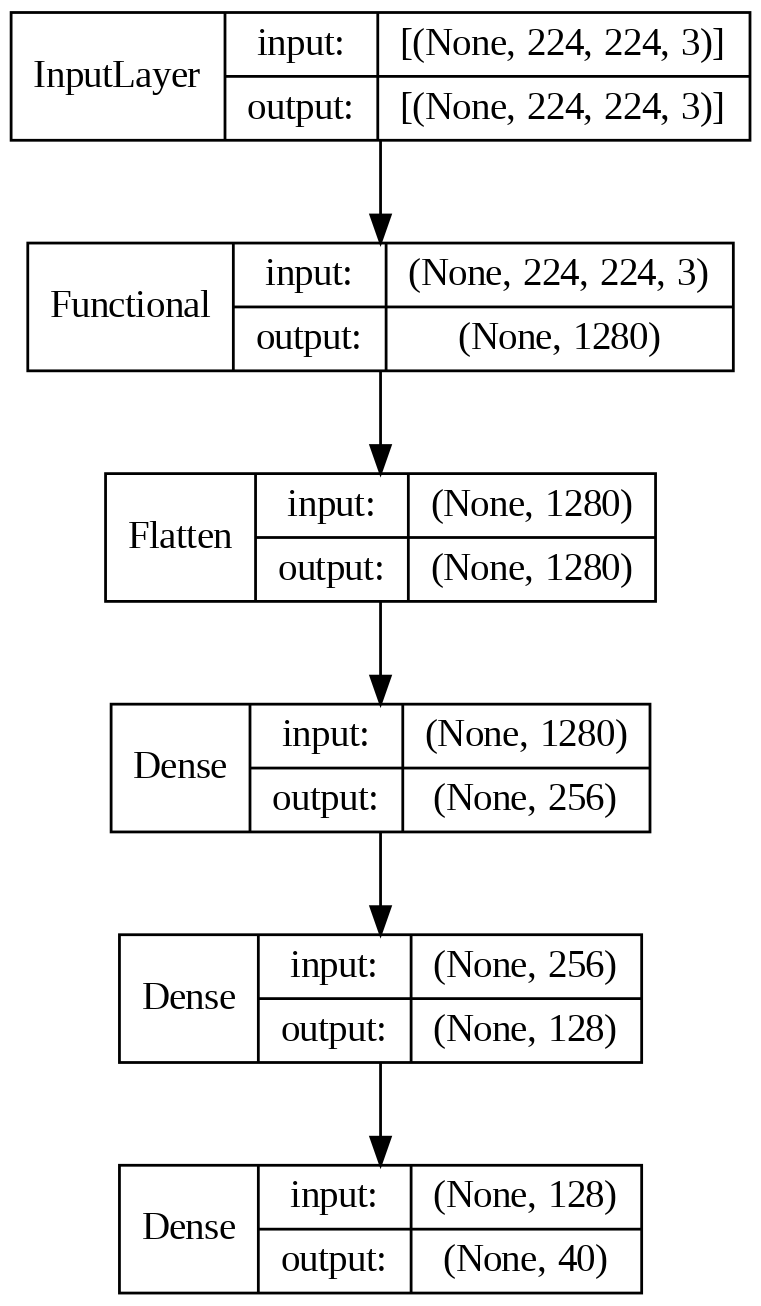

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 40)                5160      
                                                                 
Total params: 2623976 (10.01 MB)
Trainable params: 1252072 (4.78 MB)
Non-trainable params: 1371904 (5.23 MB)
_____________

In [ ]:
# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/60
99/99 [==============================] - 1041s 10s/step - loss: 1.6583 - accuracy: 0.5416 - val_loss: 1.4735 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 2/60
99/99 [==============================] - 319s 3s/step - loss: 0.8198 - accuracy: 0.7435 - val_loss: 1.2943 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 3/60
99/99 [==============================] - 309s 3s/step - loss: 0.6494 - accuracy: 0.7910 - val_loss: 1.9147 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 4/60
99/99 [==============================] - 327s 3s/step - loss: 0.5810 - accuracy: 0.8155 - val_loss: 1.5506 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 5/60
99/99 [==============================] - 321s 3s/step - loss: 0.4854 - accuracy: 0.8324 - val_loss: 1.8096 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 6/60
99/99 [==============================] - 311s 3s/step - loss: 0.3341 - accuracy: 0.8809 - val_loss: 0.7192 - val_accuracy: 0.8222 - lr: 5.0000e-04
Epoch 7/60
99/99 [==============================] - 317s 3s/step - los

In [ ]:
model.save("Ingre_scan.keras")

In [ ]:
model.save("Ingre_scan.h5")

In [ ]:
model.save('/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan2.h5', save_format="h5")

In [ ]:
model.save('/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan2.keras')

In [ ]:
# prompt: load model from drive

from tensorflow.keras.models import load_model

history = load_model('/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan')


In [ ]:
result_df = pd.DataFrame(history.history)
result_df.tail()

,loss,accuracy,val_loss,val_accuracy,lr
55,0.032617,0.988531,0.097317,0.972222,0.000004
56,0.028438,0.989169,0.095646,0.969444,0.000004
57,0.028067,0.990124,0.095885,0.969444,0.000002
58,0.027169,0.989806,0.095166,0.969444,0.000002
59,0.030816,0.987576,0.094860,0.972222,0.000002


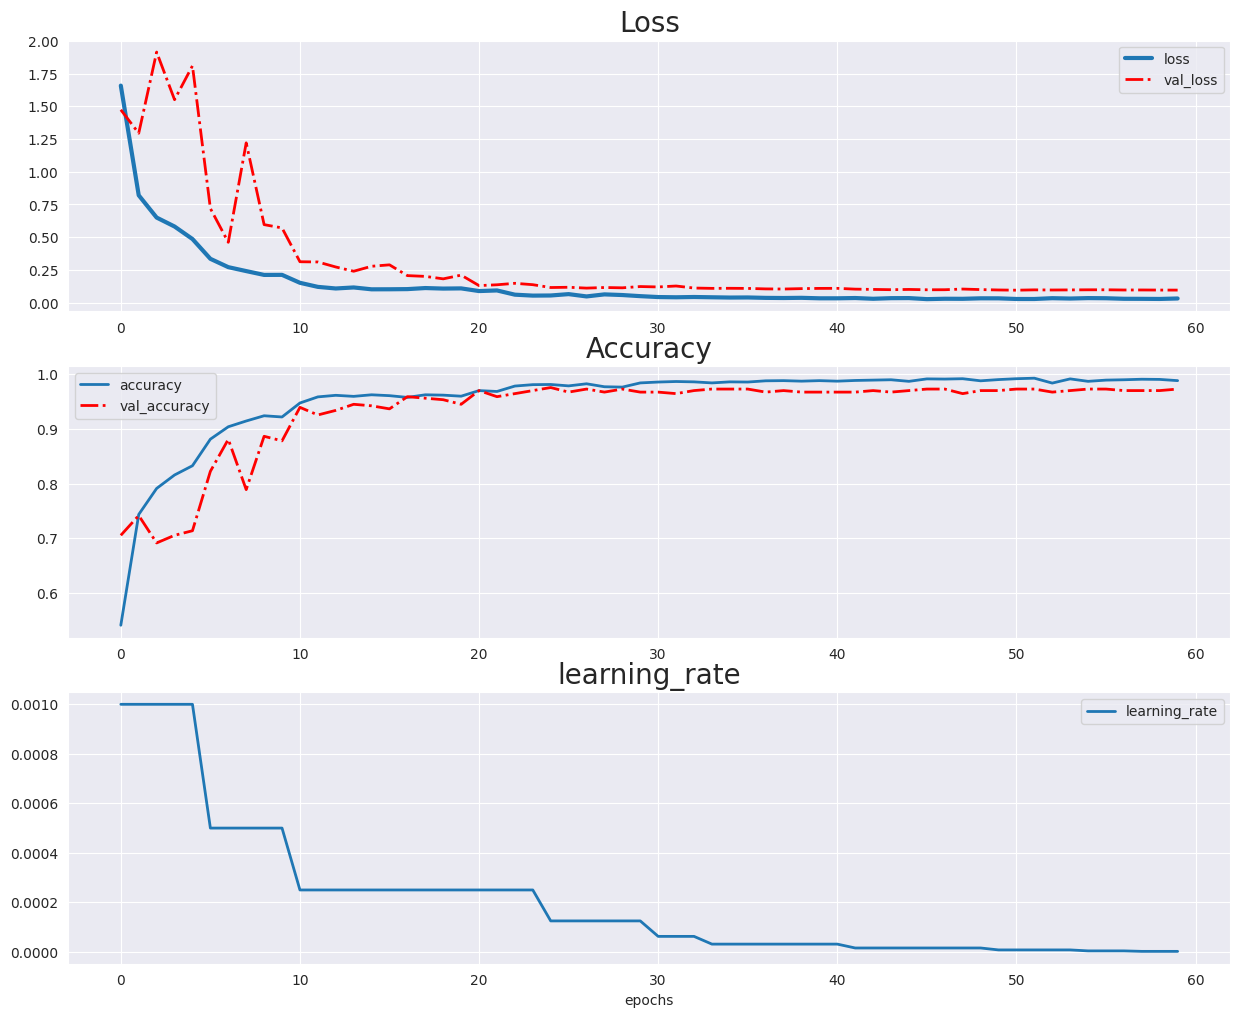

In [ ]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

In [ ]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = models.load_model('/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan.keras')

In [ ]:
test_loss, test_acc = best_model.evaluate_generator(test_generator)
train_loss, train_acc = best_model.evaluate_generator(train_generator)

print(colored(f'Train Loss : {round(train_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Train Accuracy : {round(train_acc, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

<ipython-input-18-e8d00886c923>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = best_model.evaluate_generator(test_generator)
<ipython-input-18-e8d00886c923>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_acc = best_model.evaluate_generator(train_generator)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss : 0.033
Train Accuracy : 0.988
Test Loss : 0.192
Test Accuracy : 0.965


In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
second_model = models.load_model('/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan')

In [ ]:
evaluate_model_performance(best_model, train_generator, classes)
# evaluate_model_performance(second_model, train_generator, classes)


NameError: name 'evaluate_model_performance' is not defined

In [ ]:
model.save('/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan3.h5', save_format="h5")

In [ ]:
model.save('/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan3.keras')

In [ ]:
class_names = ['apple', 'banana', 'beetroot', 'bell pepper', 'black paper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chana dal', 'chilli pepper', 'corn', 'cucumber', 'eggplant',
                 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'long clove', 'mango', 'onion', 'orange', 'paprika', 'pear', 'pineapple', 'pomegranate', 'potato',
                 'raddish', 'rice', 'soy beans', 'spinach', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
def predict_class(image_url, best_model):
  # class_names1 = [ 'apple','banana', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate','pineapple', 'mango', 'cucumber', 'carrot', 'capsicum', 'onion', 'potato', 'lemon', 'tomato', 'raddish', 'beetroot', 'cabbage', 'lettuce', 'spinach', 'soy bean','cauliflower', 'bell pepper', 'chilli pepper', 'turnip', 'corn', 'sweetcorn', 'sweet potato', 'paprika', 'jalepeño', 'ginger', 'garlic', 'peas', 'eggplant', 'rice','chana dal', 'black paper','long clove']
  # class_names = sorted(class_names1)
  class_names = ['apple', 'banana', 'beetroot', 'bell pepper', 'black paper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chana dal', 'chilli pepper', 'corn', 'cucumber', 'eggplant',
                 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'long clove', 'mango', 'onion', 'orange', 'paprika', 'pear', 'pineapple', 'pomegranate', 'potato',
                 'raddish', 'rice', 'soy beans', 'spinach', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
  img = cv2.imread(image_url, cv2.IMREAD_COLOR )
  img = cv2.resize(img, (224,224), interpolation= cv2.INTER_LINEAR )
  prediction = best_model.predict(np.expand_dims(img,0))
  indices = list(prediction[0].argsort()[-5:][::-1])
  print(prediction,indices,[class_names[i] for i in indices])
  my_class = class_names[np.argmax(prediction)]
  return my_class

In [ ]:
#image_url = '/content/drive/MyDrive/arsal_cv_proj/new/train/tomato/image_7.jpg'
image_url = '/content/drive/MyDrive/arsal_cv_proj/delish-u-rice-2-1529079587.jpg'
# new_model = tf.keras.models.load_model("/content/drive/MyDrive/arsal_cv_proj/new/Ingre_scan")
predicted_class = predict_class(image_url,best_model)
print(predicted_class)

1/1 [==============================] - 2s 2s/step
[[5.0870277e-02 2.5235147e-05 2.4747529e-05 3.0034187e-04 8.3370708e-08
  5.4870296e-05 1.3791233e-04 2.2509630e-04 3.4548520e-05 9.9199106e-06
  2.5497719e-05 4.0960491e-05 1.7774677e-05 3.7105914e-04 1.0995823e-04
  7.8043481e-04 8.2102279e-06 9.5955213e-05 4.9851509e-04 7.3071767e-04
  3.2382461e-05 1.7594775e-05 1.4069566e-03 1.0337090e-02 9.1871095e-01
  9.0845970e-05 6.6224908e-05 1.2645937e-07 1.4361595e-04 1.8085221e-04
  3.4455045e-03 3.7222642e-05 3.9264887e-05 1.7251672e-04 1.9380795e-05
  1.0013138e-04 2.3645388e-03 7.3242034e-03 2.1235671e-04 9.3607925e-04]] [24, 0, 23, 37, 30] ['orange', 'apple', 'onion', 'watermelon', 'raddish']
orange


In [ ]:
t_test_dir = os.path.join(base_dir, 't')

# Test generator

t_test_datagen = ImageDataGenerator(rescale=1./255,)

t_test_generator = t_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    # batch_size=32,
    seed=42,
    # shuffle=True
)

Found 370 validated image filenames belonging to 40 classes.


In [ ]:
class_names = ['apple', 'banana', 'beetroot', 'bell pepper', 'black paper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chana dal', 'chilli pepper', 'corn', 'cucumber', 'eggplant',
                 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'long clove', 'mango', 'onion', 'orange', 'paprika', 'pear', 'pineapple', 'pomegranate', 'potato',
                 'raddish', 'rice', 'soy beans', 'spinach', 'sweetpotato', 'tomato', 'turnip', 'watermelon']

In [ ]:
STEP_SIZE_TEST=t_test_generator.n//t_test_generator.batch_size
t_test_generator.reset()
# img = cv2.imread('/content/drive/MyDrive/arsal_cv_proj/images1).jpg' )
# img = cv2.resize(img, (224,224))
# np.shape(img)
# pred=best_model.predict(img)

pred=best_model.predict_generator(t_test_generator,steps=STEP_SIZE_TEST,verbose=1)
# print(test_generator)
indices=np.argmax(pred,axis=1)
predictions = [class_names[k] if k < len(class_names) else "Unknown" for k in indices]
# predictions = [class_names[k] for k in indices]
print(predictions)

<ipython-input-52-0ef956af4a8d>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=best_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)


11/11 [==============================] - 16s 1s/step
['capsicum', 'sweetpotato', 'spinach', 'banana', 'rice', 'corn', 'raddish', 'lettuce', 'cabbage', 'orange', 'corn', 'sweetpotato', 'pineapple', 'rice', 'pineapple', 'jalepeno', 'corn', 'corn', 'bell pepper', 'lemon', 'tomato', 'pear', 'raddish', 'corn', 'ginger', 'kiwi', 'cucumber', 'paprika', 'paprika', 'long clove', 'Unknown', 'lemon', 'potato', 'beetroot', 'cauliflower', 'lettuce', 'watermelon', 'Unknown', 'pineapple', 'mango', 'garlic', 'chilli pepper', 'sweetpotato', 'eggplant', 'lemon', 'orange', 'Unknown', 'rice', 'tomato', 'potato', 'beetroot', 'onion', 'cauliflower', 'eggplant', 'ginger', 'apple', 'Unknown', 'tomato', 'beetroot', 'raddish', 'kiwi', 'lemon', 'raddish', 'potato', 'cucumber', 'raddish', 'cucumber', 'capsicum', 'carrot', 'turnip', 'Unknown', 'paprika', 'jalepeno', 'chilli pepper', 'apple', 'paprika', 'raddish', 'turnip', 'beetroot', 'spinach', 'watermelon', 'cauliflower', 'tomato', 'lettuce', 'lettuce', 'capsicu

In [ ]:
num_images_to_predict = 1

# Run prediction on only 3 images
pred = best_model.predict_generator(t_test_generator, steps=num_images_to_predict, verbose=1)

# Get the indices of the predicted classes
indices = np.argmax(pred, axis=1)
predictions = []
# Map indices to class names
predictions = [class_names[k] if k < len(class_names) else "Unknown" for k in indices]

# Print the predictions
print(predictions, len(predictions))

<ipython-input-59-cc869b8f9a4b>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = best_model.predict_generator(t_test_generator, steps=num_images_to_predict, verbose=1)


1/1 [==============================] - 4s 4s/step
['ginger', 'lemon', 'pineapple', 'turnip', 'sweetpotato', 'Unknown', 'potato', 'tomato', 'capsicum', 'mango', 'turnip', 'orange', 'bell pepper', 'chana dal', 'garlic', 'beetroot', 'Unknown', 'cucumber', 'paprika', 'orange', 'spinach', 'pear', 'pear', 'orange', 'paprika', 'beetroot', 'pear', 'raddish', 'lettuce', 'jalepeno', 'spinach', 'garlic'] 32


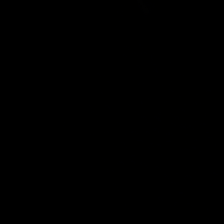

Image 1 Path: /content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_1.jpg


<ipython-input-64-a6a216ea401a>:25: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = best_model.predict_generator(t_test_generator, steps=num_images_to_predict, verbose=1)


1/1 [==============================] - 3s 3s/step
['carrot', 'cauliflower', 'ginger', 'cabbage', 'bell pepper', 'capsicum', 'eggplant', 'kiwi', 'turnip', 'cauliflower', 'eggplant', 'capsicum', 'potato', 'onion', 'grapes', 'banana', 'cabbage', 'paprika', 'Unknown', 'corn', 'potato', 'onion', 'bell pepper', 'lemon', 'garlic', 'Unknown', 'spinach', 'paprika', 'eggplant', 'chilli pepper', 'capsicum', 'cauliflower']


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Specify the number of images you want to predict (3 in this case)
num_images_to_predict = 1

# Loop through the first 3 images from t_test_generator
for i in range(num_images_to_predict):
    # Get the next batch from the generator
    batch = t_test_generator.next()

    # Extract the image and its path from the batch
    img = batch[0][0]  # Assuming the image is the first element in the batch
    img_path = t_test_generator.filepaths[i]

    # Display the image
    cv2_imshow(img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Print the image path
    print(f"Image {i + 1} Path: {img_path}")

# Run prediction on only 3 images
pred = best_model.predict_generator(t_test_generator, steps=num_images_to_predict, verbose=1)

# Get the indices of the predicted classes
indices = np.argmax(pred, axis=1)

# Map indices to class names
predictions = [class_names[k] if k < len(class_names) else "Unknown" for k in indices]

# Print the predictions
print(predictions)


(32, 224, 224, 3)


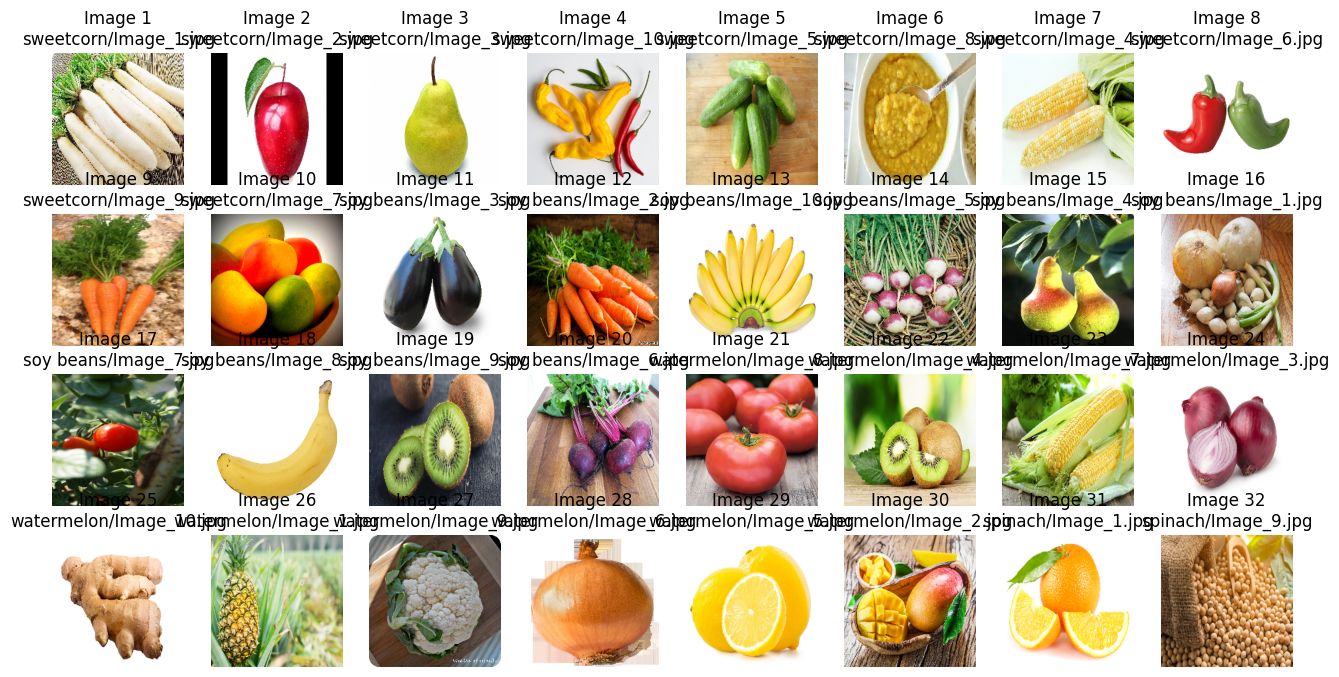

1/1 [==============================] - 1s 1s/step
['raddish', 'apple', 'pear', 'chilli pepper', 'cucumber', 'chana dal', 'corn', 'chilli pepper', 'carrot', 'mango', 'eggplant', 'carrot', 'banana', 'turnip', 'pear', 'onion', 'tomato', 'banana', 'kiwi', 'beetroot', 'tomato', 'kiwi', 'corn', 'onion', 'ginger', 'pineapple', 'cauliflower', 'onion', 'lemon', 'mango', 'orange', 'soy beans']


In [ ]:
import cv2
import matplotlib.pyplot as plt
t_test_generator.reset()
# Set the number of images in a batch
batch_size = 32

# Get a single batch from the generator
batch = t_test_generator.next()

# Extract images and paths from the batch
images = batch[0]
#image_paths = t_test_generator.filepaths[:batch_size]
print(images.shape)

# Display all images in the batch
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.ravel()

for i in range(len(images)):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f"Image {i + 1}\n{image_paths[i][46:]}")

plt.show()

# Run prediction on the entire batch
pred = best_model.predict(images)

# Get the indices of the predicted classes
indices = np.argmax(pred, axis=1)

# Map indices to class names
predictions = [class_names[k] for k in indices]

# Print the predictions
print(predictions)

In [ ]:
class_names = list(t_test_generator.class_indices.keys())
print(len(class_names))
print(class_names)

40
['apple', 'banana', 'beetroot', 'bell pepper', 'black paper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chana dal', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'long clove', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'rice', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


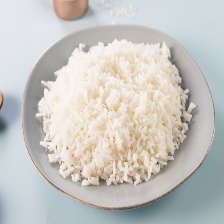

1/1 [==============================] - 0s 60ms/step
Prediction: rice


In [ ]:
class_names = ['apple', 'banana', 'beetroot', 'bell pepper', 'black paper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chana dal', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'long clove', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'rice', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
image_url = '/content/drive/MyDrive/arsal_cv_proj/delish-u-rice-2-1529079587.jpg'
img = cv2.imread(image_url)
img = cv2.resize(img, (224,224), interpolation= cv2.INTER_LINEAR )
cv2_imshow(img)
img = img / 255.0  # Normalize the image
img = np.expand_dims(img, axis=0)
pred = best_model.predict(img)
indices = np.argmax(pred, axis=1)
predictions = [class_names[k] for k in indices]
print("Prediction:",predictions[0])


In [ ]:
img = cv2.imread(image_url)
if img is not None:
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)

    pred = best_model.predict(img)
    indices = np.argmax(pred, axis=1)
    predictions = [class_names[k] for k in indices]

    print("Label:", class_names[class_num])
    print("Prediction:", predictions)
else:
    print("Error loading the image.")

1/1 [==============================] - 0s 36ms/step
Label: raddish
Prediction: ['raddish']


1/1 [==============================] - 0s 89ms/step
['capsicum']


In [ ]:
print(len(predictions))

32


In [ ]:
print(test_generator.filenames)
print(len(test_generator.filenames))

['/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_1.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_2.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_3.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_10.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_5.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_8.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_4.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_6.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_9.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_7.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_3.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_2.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_10.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_5.jpg', '/c

In [ ]:
print(test_generator.filepaths)


['/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_1.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_2.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_3.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_10.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_5.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_8.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_4.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_6.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_9.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/sweetcorn/Image_7.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_3.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_2.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_10.jpg', '/content/drive/MyDrive/arsal_cv_proj/new/test/soy beans/Image_5.jpg', '/c